In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

https://www.bls.gov/oes/current/naics3_334000.htm

https://fred.stlouisfed.org/series/PCU488330488330P

In [30]:
df = pd.read_csv('Navigational Services to Shipping.csv')

In [31]:
df.head()

,DATE,PCU488330488330P
0,1992-12-01,100.0
1,1993-01-01,100.0
2,1993-02-01,100.0
3,1993-03-01,100.0
4,1993-04-01,100.1


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              368 non-null    object 
 1   PCU488330488330P  368 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.9+ KB


In [33]:
df['Price'] = df['PCU488330488330P']
df_new = df.drop(['PCU488330488330P'],axis=1)
df_new['Date']= pd.to_datetime(df_new['DATE'])
df_new =  df_new.set_index(df_new['Date'])
df_new.drop(['Date','DATE'], axis=1 , inplace=True)
df_new.head()

,Price
Date,
1992-12-01,100.0
1993-01-01,100.0
1993-02-01,100.0
1993-03-01,100.0
1993-04-01,100.1


In [34]:
# df_new.to_csv('Navigational_Services.csv', index= True)

<Axes: xlabel='Date'>

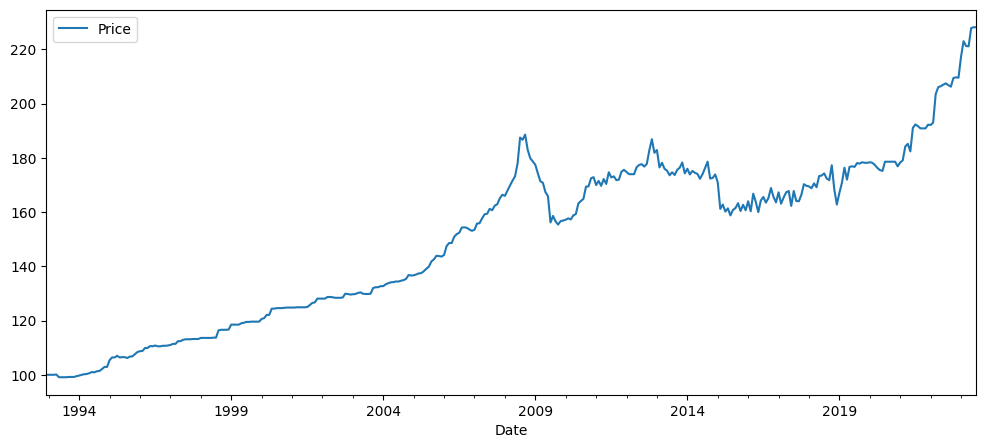

In [35]:
df_new.plot(figsize=(12,5))

## Data Cleaning

In [36]:
df_new.isnull().sum()

Price    0
dtype: int64

In [37]:
# df.dropna(inplace = True)
# df.reset_index(drop=False,inplace=True)

In [38]:
df_new.shape

(368, 1)

In [39]:
df_new = df_new.iloc[:]

In [40]:
df_new.shape

(368, 1)

In [41]:
df_new = df_new.sort_values('Date', ascending=True)
df_new.index.freq = 'MS'

In [42]:
df_new.head()

,Price
Date,
1992-12-01,100.0
1993-01-01,100.0
1993-02-01,100.0
1993-03-01,100.0
1993-04-01,100.1


In [43]:
# df_new = df_new.iloc[110:]

<Axes: xlabel='Date', ylabel='Price'>

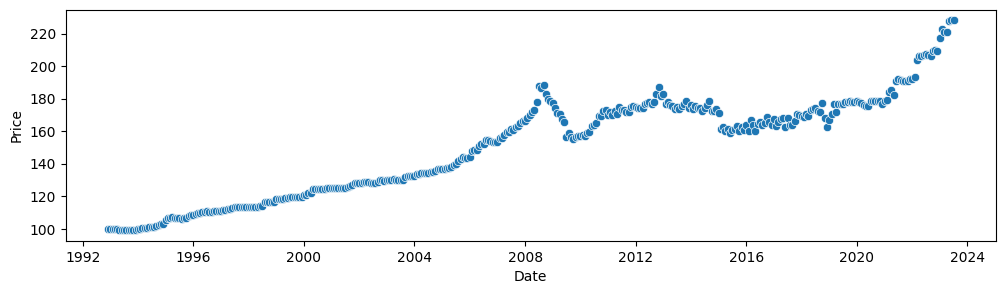

In [44]:
plt.figure(figsize=(12,3))

sns.scatterplot(x=df_new.index, y=df_new['Price'])

<Axes: >

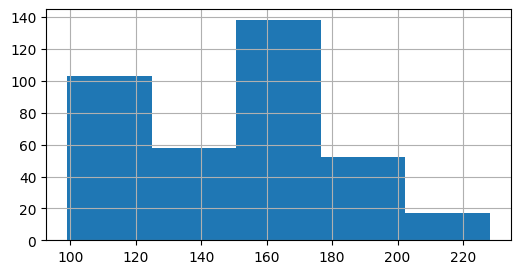

In [45]:
plt.figure(figsize=(6,3))

df_new['Price'].hist(bins=5)

<Axes: >

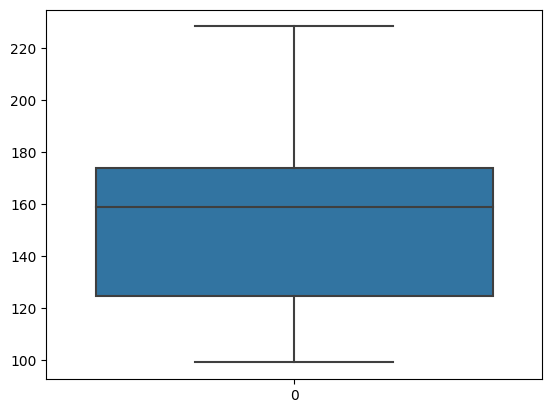

In [46]:
sns.boxplot(df_new['Price'])

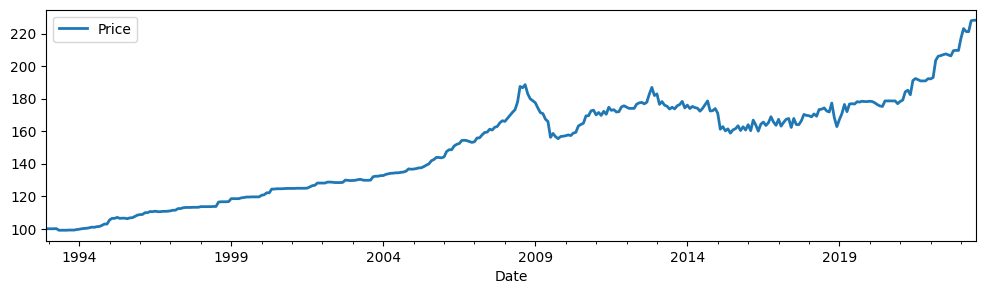

In [47]:
df_new.plot.line(y='Price',figsize=(12,3),lw=2);

<Axes: title={'center': 'Seasonality of the Time Series'}, xlabel='Month', ylabel='Price'>

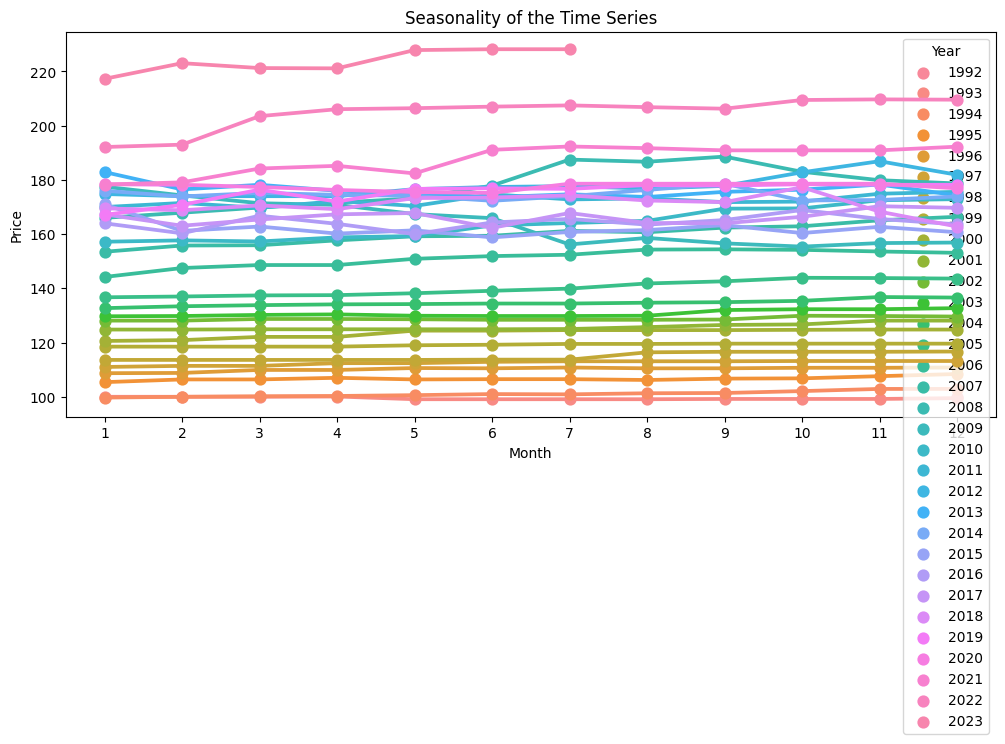

In [48]:
# To plot the seasonality we are going to create a temp dataframe and add columns for Month and Year values
df_temp = df_new.copy()
df_temp['Year'] = pd.DatetimeIndex(df_temp.index).year
df_temp['Month'] = pd.DatetimeIndex(df_temp.index).month
# Stacked line plot
plt.figure(figsize=(12,5))
plt.title('Seasonality of the Time Series')
sns.pointplot(x='Month',y='Price',hue='Year',data=df_temp)

https://www.metafab.com/steel-prices-growth-in-metal-fabrication/

In [49]:
df_pre = df_new[:'2020-03-1']
df_pandemic = df_new['2020-03-1':'2022-01-01']
df_post = df_new['2022-01-01':]

<Axes: xlabel='Date'>

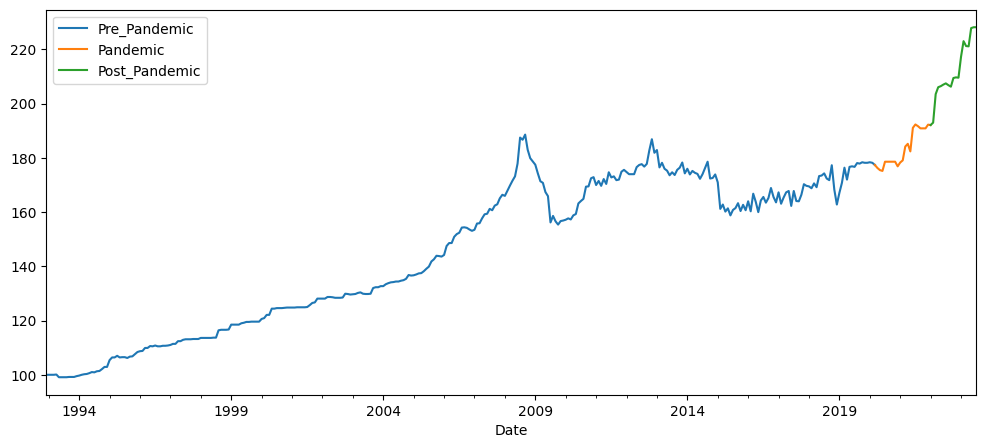

In [50]:
df_pre['Price'].plot(legend=True, label='Pre_Pandemic',figsize=(12,5))
df_pandemic['Price'].plot(legend=True, label='Pandemic')
df_post['Price'].plot(legend=True, label = 'Post_Pandemic')

## Decomposition of Time Series

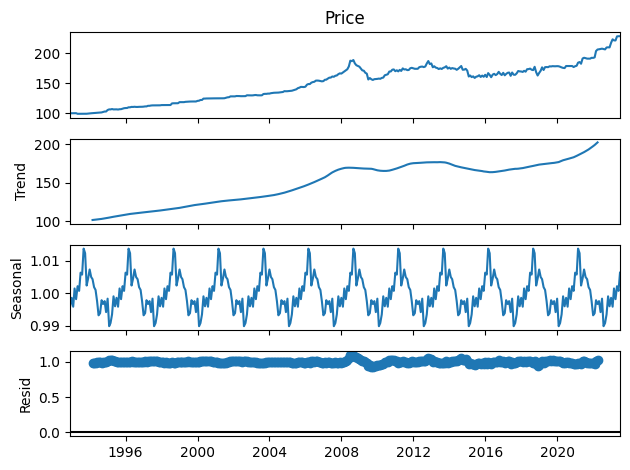

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_new['Price'], model='multiplicative',period=30)  # model='mul' also works
result.plot();

## Simple Moving Average (SMA)

In [52]:
df_new['12-month-SMA'] = df_new['Price'].rolling(window=12).mean()

<Axes: xlabel='Date'>

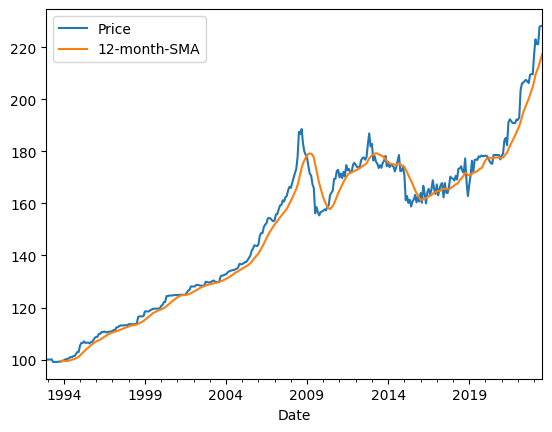

In [53]:
df_new[['Price','12-month-SMA']].plot()

## Exponentially Weighted Moving Average (EWMA)

In [54]:
df_new['EWMA12'] = df_new['Price'].ewm(span=12,adjust=False).mean()

<Axes: xlabel='Date'>

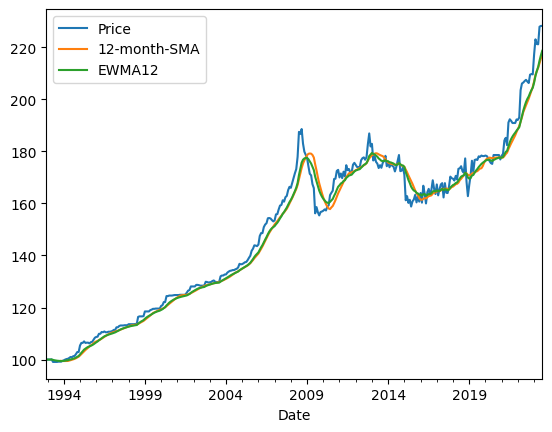

In [55]:
df_new[['Price','12-month-SMA','EWMA12']].plot()

## Comparing SMA to EWMA

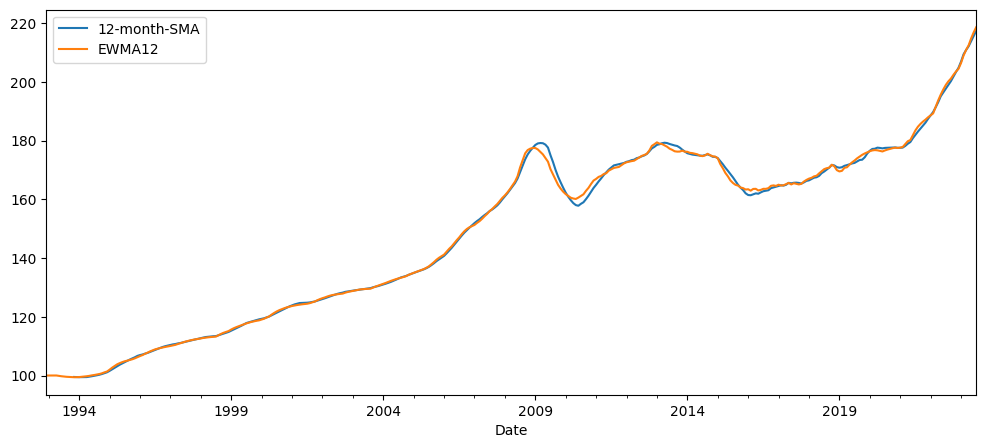

In [56]:
df_new[['12-month-SMA','EWMA12']].plot(figsize=(12,5)).autoscale(axis='x',tight=True);

https://stackoverflow.com/questions/60017052/decompose-for-time-series-valueerror-you-must-specify-a-period-or-x-must-be

## Check for Stationarity

### Augmented Dickey Fuller (ADF) Test 

#### p-value > 0.05: non-stationary.
#### p-value <= 0.05: stationary.
#### Test statistics: More negative this value more likely we have stationary series. Also, this value should be smaller than critical values(1%, 5%, 10%). For e.g. If test statistic is smaller than the 5% critical values, then we can say with 95% confidence that this is a stationary series

In [57]:
def stationarity_test(timeseries):
    # Get rolling statistics for window = 12 i.e. yearly statistics
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    
    # Plot rolling statistic
    plt.figure(figsize= (10,6))
    plt.xlabel('Month')
    plt.ylabel('Item_Price')    
    plt.title('Stationary Test: Rolling Mean and Standard Deviation')
    plt.plot(timeseries, color= 'blue', label= 'Original')
    plt.plot(rolling_mean, color= 'green', label= 'Rolling Mean')
    plt.plot(rolling_std, color= 'red', label= 'Rolling Std')   
    plt.legend()
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    df_test = adfuller(timeseries)
    df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)

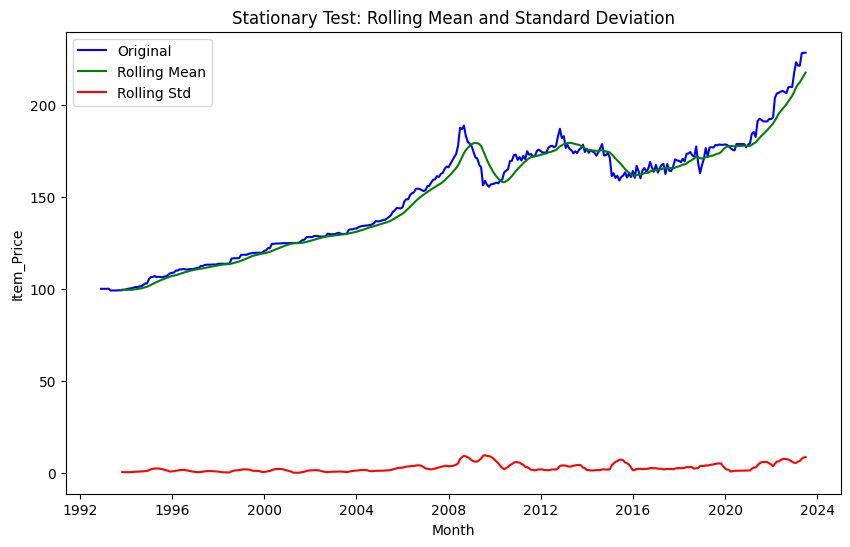

Results of Dickey-Fuller Test
Test Statistic                   0.310114
p-value                          0.977804
#Lags Used                       4.000000
Number of Observations Used    363.000000
Critical Value (1%)             -3.448494
Critical Value (5%)             -2.869535
Critical Value (10%)            -2.571029
dtype: float64


In [58]:
stationarity_test(df_new['Price'])

### Differencing

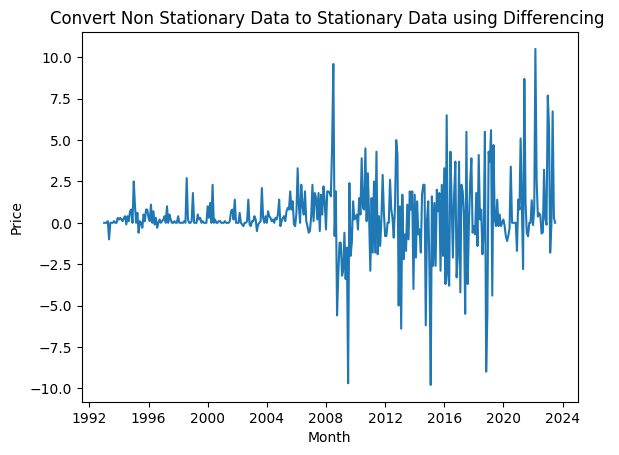

In [59]:
df_diff = df_new['Price'].diff(periods = 1) # First order differencing
plt.xlabel('Month')
plt.ylabel('Price')    
plt.title('Convert Non Stationary Data to Stationary Data using Differencing ')
plt.plot(df_diff)

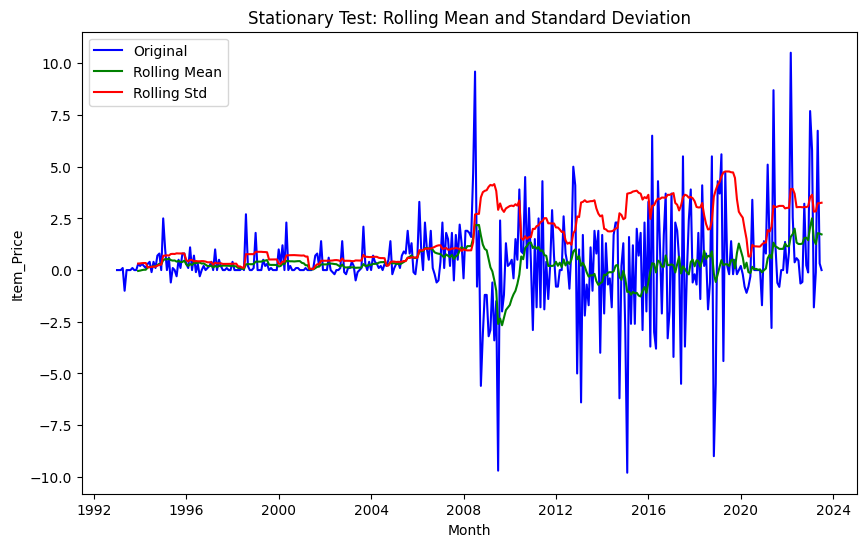

Results of Dickey-Fuller Test
Test Statistic                -7.566524e+00
p-value                        2.915890e-11
#Lags Used                     3.000000e+00
Number of Observations Used    3.630000e+02
Critical Value (1%)           -3.448494e+00
Critical Value (5%)           -2.869535e+00
Critical Value (10%)          -2.571029e+00
dtype: float64


In [60]:
df_diff.dropna(inplace = True)# Data transformation may add na values
stationarity_test(df_diff)

### Transformation

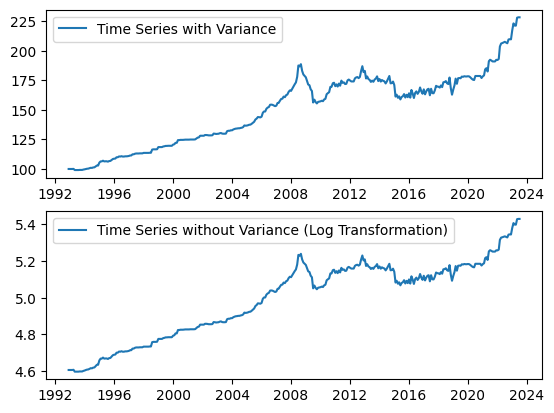

In [61]:
df_log = np.log(df_new['Price'])

plt.subplot(211)
plt.plot(df_new['Price'], label= 'Time Series with Variance')
plt.legend()
plt.subplot(212)
plt.plot(df_log, label='Time Series without Variance (Log Transformation)')
plt.legend()  
plt.show()

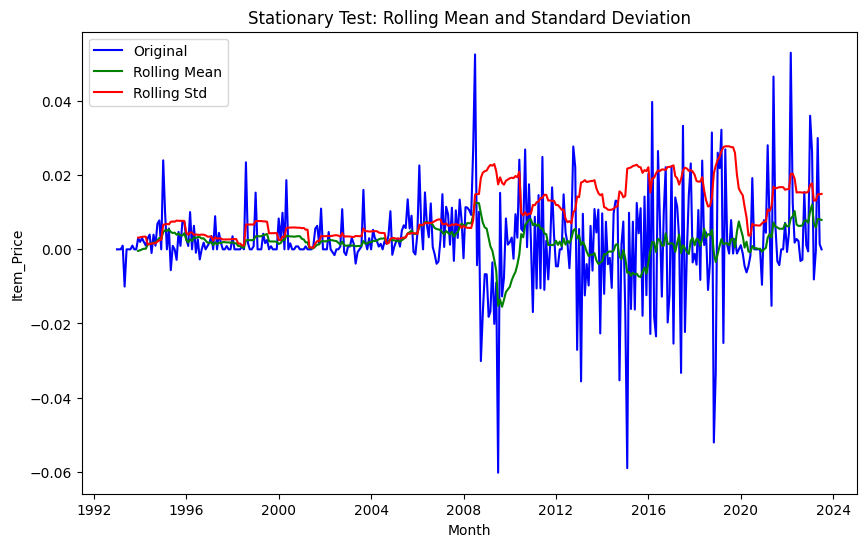

Results of Dickey-Fuller Test
Test Statistic                -7.652531e+00
p-value                        1.773684e-11
#Lags Used                     3.000000e+00
Number of Observations Used    3.630000e+02
Critical Value (1%)           -3.448494e+00
Critical Value (5%)           -2.869535e+00
Critical Value (10%)          -2.571029e+00
dtype: float64


In [62]:
df_log_diff = df_log.diff(periods = 1) # First order differencing

df_log_diff.dropna(inplace = True)# Data transformation may add na values

stationarity_test(df_log_diff)

In [63]:
df_new= df_new.drop(['12-month-SMA','EWMA12'],axis=1)

In [64]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 368 entries, 1992-12-01 to 2023-07-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   368 non-null    float64
dtypes: float64(1)
memory usage: 13.9 KB


In [65]:
# df_new['Price'].plot(figsize=(10,5))

## Forecasting with the Holt-Winters Method

### Train Test Split

In [87]:
train_data = df_new.iloc[:356] # Goes up to but not including 101
test_data = df_new.iloc[356:]

### Fitting the Model

In [88]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_data['Price'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

### Evaluating Model against Test Set

In [89]:
test_predictions = fitted_model.forecast(12).rename('HW Forecast')

In [90]:
test_predictions

2022-08-01    207.650886
2022-09-01    208.484394
2022-10-01    208.791602
2022-11-01    209.226924
2022-12-01    208.321724
2023-01-01    208.956505
2023-02-01    208.150145
2023-03-01    210.147016
2023-04-01    210.086280
2023-05-01    210.454026
2023-06-01    211.359387
2023-07-01    212.432620
Freq: MS, Name: HW Forecast, dtype: float64

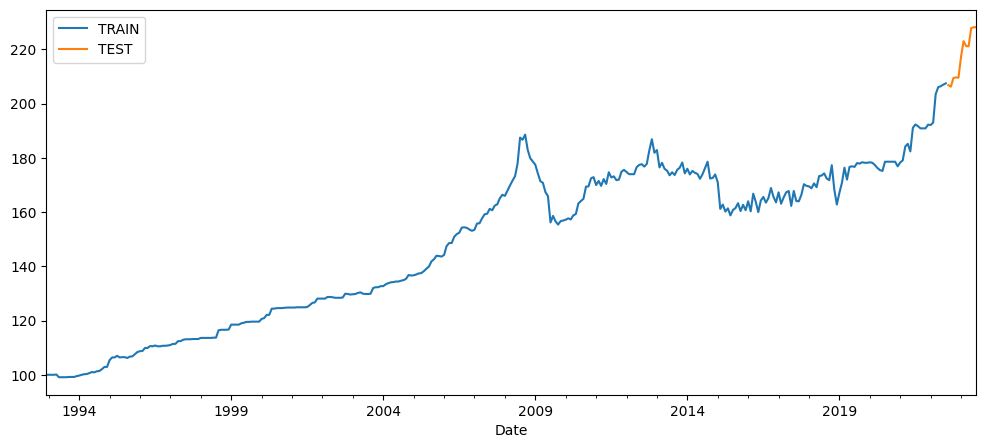

In [91]:
train_data['Price'].plot(legend=True,label='TRAIN')
test_data['Price'].plot(legend=True,label='TEST',figsize=(12,5));

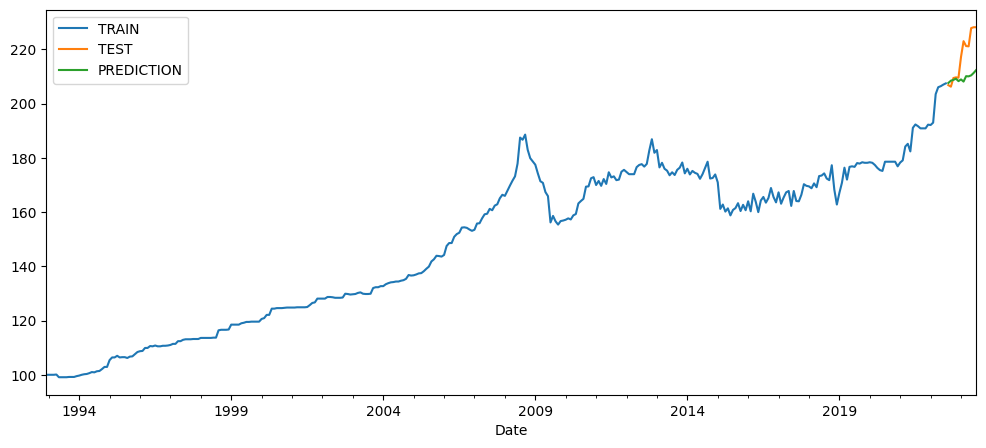

In [92]:
train_data['Price'].plot(legend=True,label='TRAIN')
test_data['Price'].plot(legend=True,label='TEST',figsize=(12,5))
test_predictions.plot(legend=True,label='PREDICTION');

In [93]:
final_model = ExponentialSmoothing(df_new['Price'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

In [94]:
forecast_predictions = final_model.forecast(12)

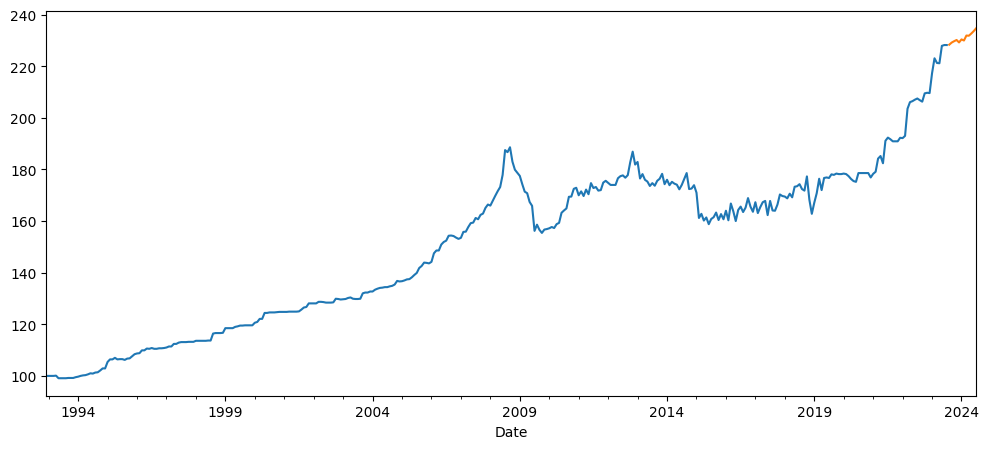

In [95]:
df_new['Price'].plot(figsize=(12,5))
forecast_predictions.plot();

### Evaluation Metrics

In [96]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [97]:
mean_absolute_error(test_data,test_predictions)

8.413920943690647

In [98]:
mean_squared_error(test_data,test_predictions)

115.24842490070104

In [99]:
np.sqrt(mean_squared_error(test_data,test_predictions))

10.73538191685331

In [100]:
df_new['Price'].describe()

count    368.000000
mean     150.431473
std       30.717337
min       99.100000
25%      124.600000
50%      159.000000
75%      174.000000
max      228.212000
Name: Price, dtype: float64

## AR(p)
### Autoregressive Model

## Lagging
Also known as "backshifting", lagging notation reflects the value of $y$ at a prior point in time. This is a useful technique for performing <em>regressions</em> as we'll see in upcoming sections.

\begin{split}L{y_t} = y_{t-1} & \text{      one lag shifts the data back one period}\\
L^{2}{y_t} = y_{t-2} & \text{      two lags shift the data back two periods} \end{split}
<br><br>
<table>
<tr><td>$y_t$</td><td>6</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-1}$</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-2}$</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
</table>


In [101]:
# Load specific forecasting tools
from statsmodels.tsa.ar_model import AR,ARResults

In [102]:
from statsmodels.tsa.ar_model import AutoReg

In [103]:
df_new.head()

,Price
Date,
1992-12-01,100.0
1993-01-01,100.0
1993-02-01,100.0
1993-03-01,100.0
1993-04-01,100.1


### Fit an AR(1) Model

In [104]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [105]:
model = AutoReg(train['Price'], lags=1)
AR1fit = model.fit()
print(f'Coefficients:\n{AR1fit.params}')

Coefficients:
const      -0.073568
Price.L1    1.002946
dtype: float64


In [106]:
# This is the general format for obtaining predictions
start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

In [107]:
predictions1

2002-04-01    129.005520
2002-05-01    129.311939
2002-06-01    129.619261
2002-07-01    129.927489
2002-08-01    130.236624
                 ...    
2023-03-01    242.630884
2023-04-01    243.271989
2023-05-01    243.914982
2023-06-01    244.559869
2023-07-01    245.206656
Freq: MS, Name: AR(1) Predictions, Length: 256, dtype: float64

<Axes: xlabel='Date'>

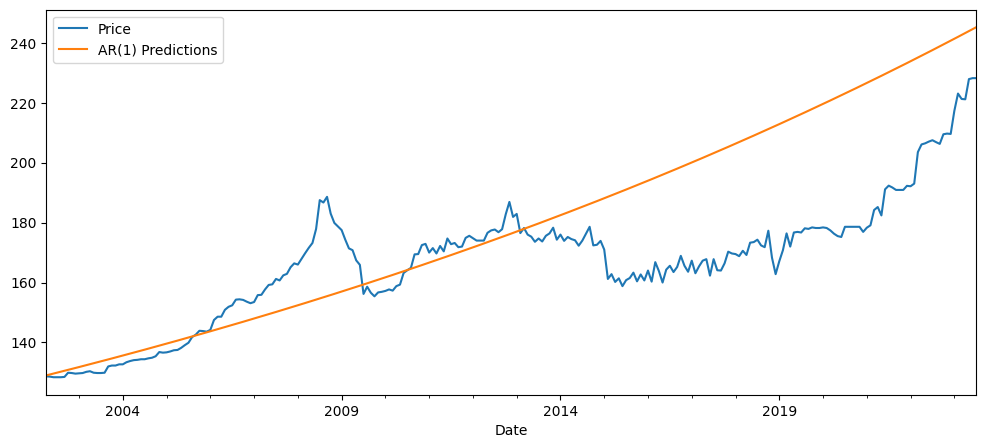

In [108]:
test.plot(figsize=(12,5), legend=True)
predictions1.plot(legend=True)

### Fit an AR(2) Model

In [109]:
model = AutoReg(train['Price'], lags=2)
AR2fit = model.fit()
print(f'Coefficients:\n{AR2fit.params}')

Coefficients:
const      -0.047490
Price.L1    0.972869
Price.L2    0.029931
dtype: float64


In [110]:
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

<Axes: xlabel='Date'>

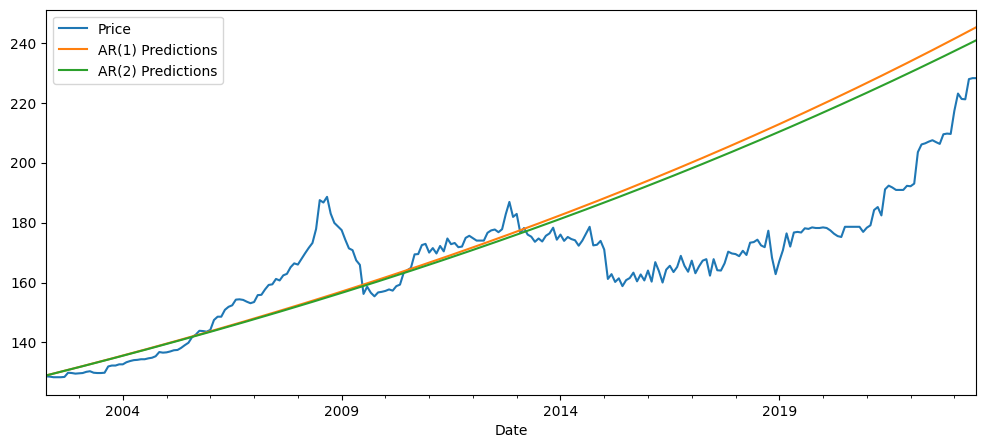

In [111]:
test.plot(figsize=(12,5), legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)

### Fit an AR(p) model where statsmodels chooses p

In [112]:
# Define a range of lags to consider
lags_range = range(1, 10)

# Initialize variables for best AIC and best lag
best_aic = float("inf")
best_lag = None

# Iterate over the lags and fit AutoReg models
for lag in lags_range:
    model = AutoReg(train['Price'], lags=lag)
    fit = model.fit()
    
    # Check if the current model has lower AIC
    if fit.aic < best_aic:
        best_aic = fit.aic
        best_lag = lag

# Fit the AutoReg model with the best lag
best_model = AutoReg(train['Price'], lags=best_lag)
best_fit = best_model.fit()
print(f'Lag: {best_lag}')
print(f'Coefficients:\n{best_fit.params}')

Lag: 8
Coefficients:
const       0.330754
Price.L1    0.942172
Price.L2    0.217183
Price.L3   -0.180134
Price.L4   -0.030564
Price.L5    0.138381
Price.L6   -0.203664
Price.L7   -0.068049
Price.L8    0.184657
dtype: float64


In [113]:
model = AutoReg(train['Price'], lags=9)
AR9fit = model.fit()
print(f'Coefficients:\n{AR9fit.params}')

Coefficients:
const       0.401538
Price.L1    0.935125
Price.L2    0.216740
Price.L3   -0.185459
Price.L4   -0.020246
Price.L5    0.140500
Price.L6   -0.201220
Price.L7   -0.074694
Price.L8    0.161659
Price.L9    0.027115
dtype: float64


In [114]:
predictions9 = AR9fit.predict(start=start, end=end, dynamic=False).rename('AR(9) Predictions')

<Axes: xlabel='Date'>

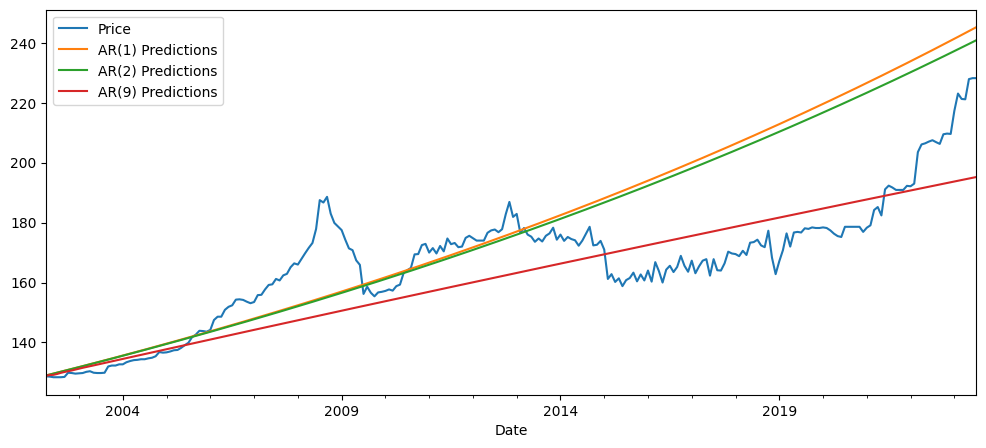

In [115]:
test.plot(figsize=(12,5), legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions9.plot(legend=True)

### Evaluate the Model
It helps to have a means of comparison between two or more models. One common method is to compute the Mean Squared Error (MSE), available from scikit-learn

In [116]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(9)']
preds = [predictions1, predictions2, predictions9]  # these are variables, not strings!

for i in range(3):
    error = mean_squared_error(test['Price'], preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error:  588.918938
AR(2) Error: 514.2964278
AR(9) Error: 160.4234679


In [117]:
np.sqrt(mean_squared_error(test['Price'],predictions9))

12.66583861775206

Another method is the Akaike information criterion (AIC), which does a better job of evaluating models by avoiding overfitting.
Fortunately this is available directly from the fit model object.

In [118]:
modls = [AR1fit,AR2fit,AR9fit]

for i in range(3):
    print(f'{labels[i]} AIC: {modls[i].aic:6.5}')

AR(1) AIC: 179.53
AR(2) AIC: 180.69
AR(9) AIC: 175.01


### Forecasting
Now we're ready to train our best model on the greatest amount of data, and fit it to future dates.

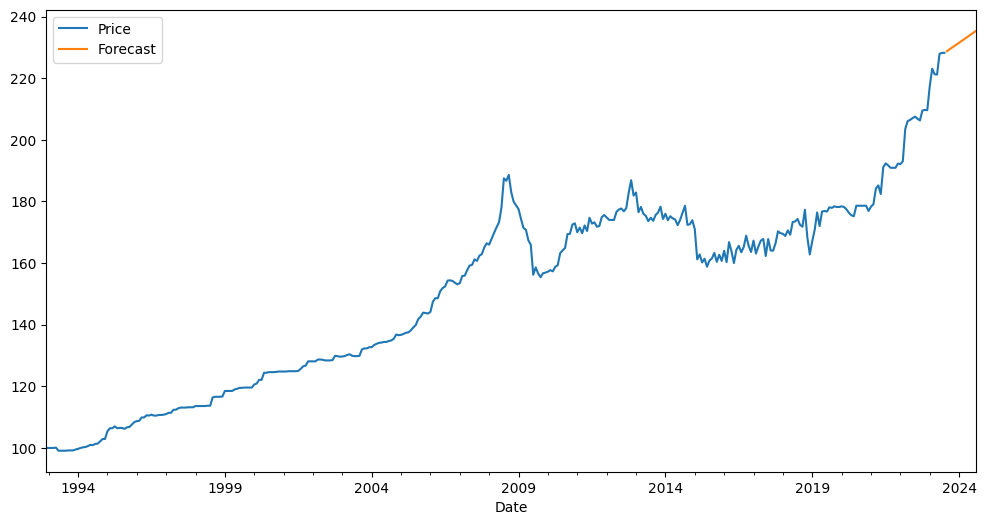

In [119]:
# First, retrain the model on the full dataset
model = AutoReg(df_new['Price'], lags=1)

# Next, fit the model
AR1fit = model.fit()

# Make predictions
fcast = AR1fit.predict(start=len(df_new), end=len(df_new)+12, dynamic=False).rename('Forecast')

# Plot the results
df_new['Price'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,6));

## pmdarima Auto-ARIMA

In [120]:
df_new.head()

,Price
Date,
1992-12-01,100.0
1993-01-01,100.0
1993-02-01,100.0
1993-03-01,100.0
1993-04-01,100.1


In [121]:
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [122]:
auto_arima(df_new['Price'],seasonal=False)

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

In [123]:
auto_arima(df_new['Price'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  368
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -807.590
Date:                Wed, 16 Aug 2023   AIC                           1623.181
Time:                        12:49:19   BIC                           1638.802
Sample:                    12-01-1992   HQIC                          1629.388
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6916      0.228      3.028      0.002       0.244       1.139
ar.L1         -0.9815      0.014    -70.112      0.000      -1.009      -0.954
ma.L1          0.9469      0.026     36.702      0.000       0.896       0.997
sigma2         4.7703      0.175     27.259      0.000       4.427       5.113
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               601.60
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):              31.80   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Run the augmented Dickey-Fuller Test on the original data

In [124]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [125]:
adf_test(df_new['Price'],'Price')

Augmented Dickey-Fuller Test: Price
ADF test statistic        0.310114
p-value                   0.977804
# lags used               4.000000
# observations          363.000000
critical value (1%)      -3.448494
critical value (5%)      -2.869535
critical value (10%)     -2.571029
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### Run the augmented Dickey-Fuller Test on the First and Second Difference

In [126]:
from statsmodels.tsa.statespace.tools import diff
df_new['d1'] = diff(df_new['Price'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df_new['d1'],'Price')

Augmented Dickey-Fuller Test: Price
ADF test statistic     -7.566524e+00
p-value                 2.915890e-11
# lags used             3.000000e+00
# observations          3.630000e+02
critical value (1%)    -3.448494e+00
critical value (5%)    -2.869535e+00
critical value (10%)   -2.571029e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [127]:
from statsmodels.tsa.statespace.tools import diff
df_new['d2'] = diff(df_new['Price'],k_diff=2)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df_new['d2'],'Price')

Augmented Dickey-Fuller Test: Price
ADF test statistic     -1.172075e+01
p-value                 1.415361e-21
# lags used             8.000000e+00
# observations          3.570000e+02
critical value (1%)    -3.448801e+00
critical value (5%)    -2.869670e+00
critical value (10%)   -2.571101e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Run the ACF and PACF plots
This confirms that we reached stationarity after the first difference.
A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>

In [128]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

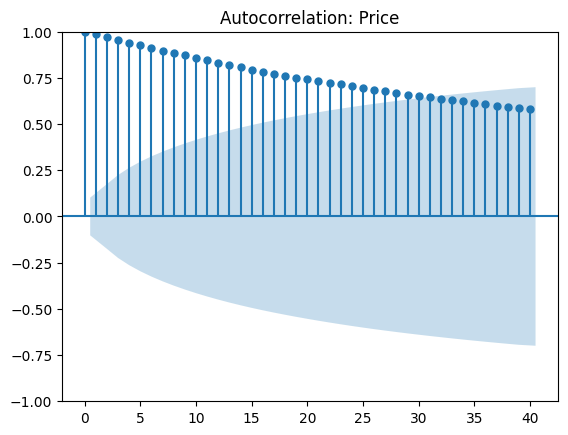

In [129]:
title = 'Autocorrelation: Price'
lags = 40
plot_acf(df_new['Price'],title=title,lags=lags);

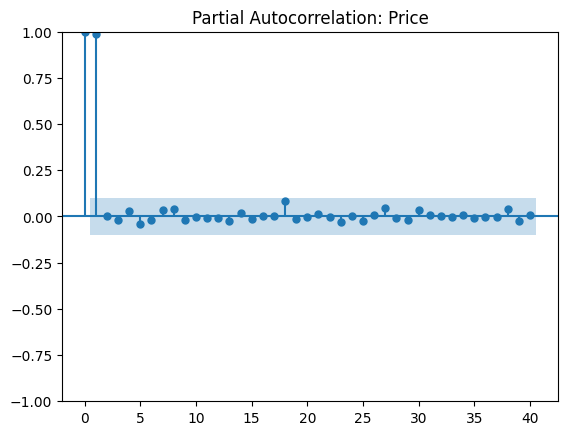

In [130]:
title = 'Partial Autocorrelation: Price'
lags = 40
plot_pacf(df_new['Price'],title=title,lags=lags);

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

### ARIMA Model

In [131]:
# Load specific forecasting tools

from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

In [133]:
model = ARIMA(train['Price'],order=((1,1,1)))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  112
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -89.043
Date:                Wed, 16 Aug 2023   AIC                            184.086
Time:                        12:49:59   BIC                            192.214
Sample:                    12-01-1992   HQIC                           187.383
                         - 03-01-2002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.005    219.222      0.000       0.991       1.009
ma.L1         -0.9972      0.355     -2.809      0.005      -1.693      -0.301
sigma2         0.2837      0.096      2.969      0.003       0.096       0.471
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):               339.69
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             2.33
Prob(H) (two-sided):                  0.60   Kurtosis:                        10.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [134]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARIMA((2,1,2)) Predictions')

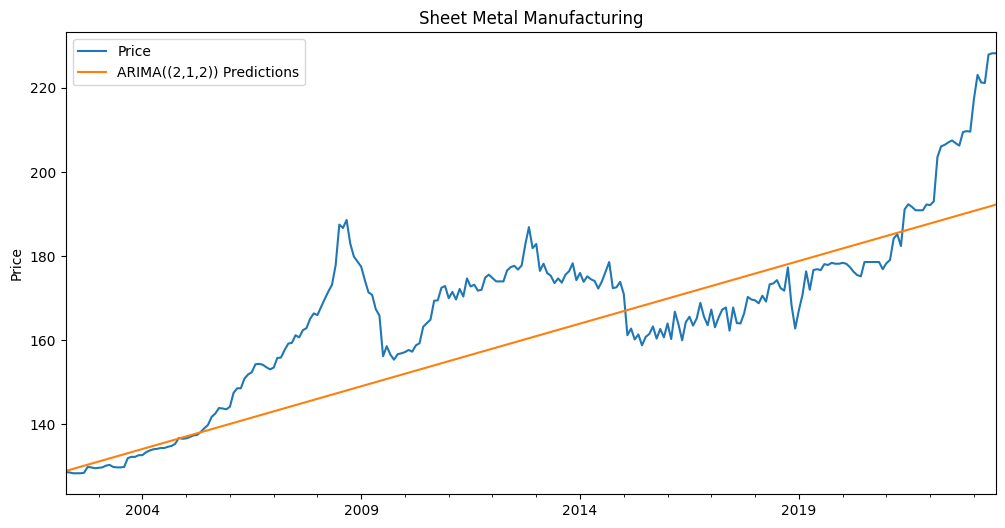

In [135]:
title = 'Sheet Metal Manufacturing'
ylabel='Price'
xlabel='' # we don't really need a label here

ax = test['Price'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [136]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA((2,1,2) Predictions')

Passing dynamic=False means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing typ='levels' predicts the levels of the original endogenous variables. If we'd used the default typ='linear' we would have seen linear predictions in terms of the differenced endogenous variables.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [137]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Price'][i]}")

predicted=128.9487229, expected=128.7
predicted=129.1974415, expected=128.6
predicted=129.4461556, expected=128.4
predicted=129.6948653, expected=128.4
predicted=129.9435705, expected=128.4
predicted=130.1922714, expected=128.5
predicted=130.4409678, expected=129.9
predicted=130.6896598, expected=129.8
predicted=130.9383474, expected=129.6
predicted=131.1870306, expected=129.7
predicted=131.4357093, expected=129.8
predicted=131.6843837, expected=130.2
predicted=131.9330536, expected=130.4
predicted=132.1817191, expected=129.9
predicted=132.4303801, expected=129.8
predicted=132.6790368, expected=129.8
predicted=132.927689 , expected=129.9
predicted=133.1763368, expected=132.0
predicted=133.4249802, expected=132.3
predicted=133.6736192, expected=132.3
predicted=133.9222538, expected=132.7
predicted=134.1708839, expected=132.7
predicted=134.4195096, expected=133.4
predicted=134.6681309, expected=133.8
predicted=134.9167478, expected=134.1
predicted=135.1653603, expected=134.2
predicted=13

In [138]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

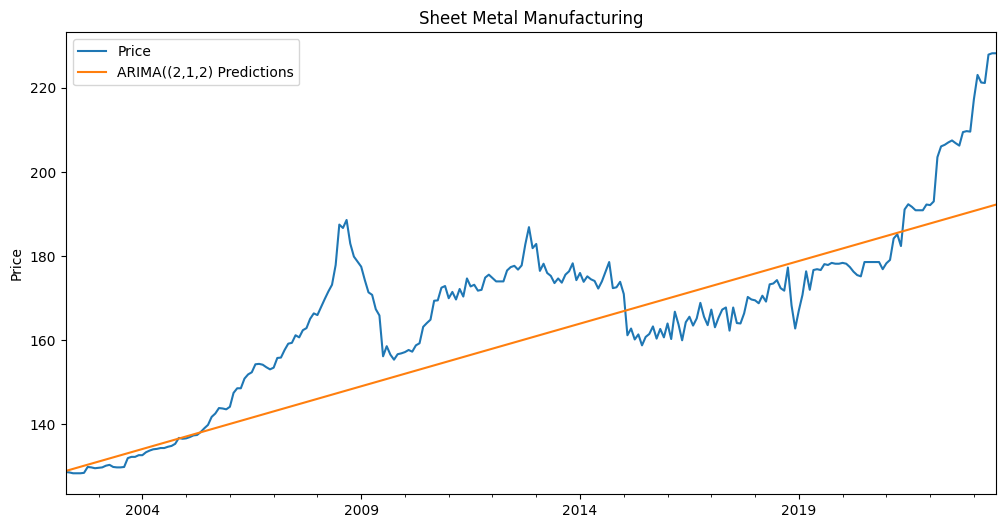

In [139]:
# Plot predictions against known values
title = 'Sheet Metal Manufacturing'
ylabel='Price'
xlabel='' # we don't really need a label here

ax = test['Price'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Evaluate the Model

In [140]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Price'], predictions)
print(f'ARIMA(2,1,2) MSE Error: {error:11.10}')

ARIMA(2,1,2) MSE Error: 178.3223707


In [141]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Price'], predictions)
print(f'ARIMA(2,1,2) RMSE Error: {error:11.10}')

ARIMA(2,1,2) RMSE Error: 13.35373995


In [142]:
df_new['Price'].mean()

150.43147282608695

In [143]:
predictions.mean()

160.61267455549373

### Retrain the model on the full data, and forecast the future

In [144]:
model = ARIMA(df_new['Price'],order=(2,1,2))
results = model.fit()
fcast = results.predict(len(df_new),len(df_new)+11,typ='levels').rename('ARIMA(2,1,2) Forecast')

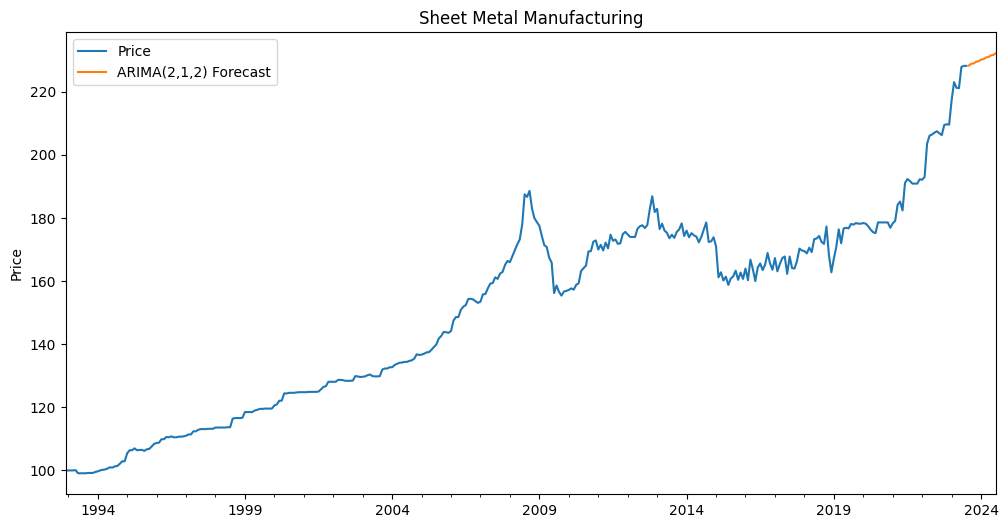

In [145]:
# Plot predictions against known values
title = 'Sheet Metal Manufacturing'
ylabel='Price'
xlabel='' # we don't really need a label here

ax = df_new['Price'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# SARIMA(p,d,q)(P,D,Q)m
# Seasonal Autoregressive Integrated Moving Averages

In [98]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [99]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df_new['Price'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -413.326
Date:                Tue, 15 Aug 2023   AIC                            834.651
Time:                        12:35:17   BIC                            848.455
Sample:                    12-01-2003   HQIC                           840.218
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2060      0.128      1.604      0.109      -0.046       0.458
ar.L1          0.2409      0.048      5.035      0.000       0.147       0.335
ar.L2          0.4464      0.046      9.770      0.000       0.357       0.536
sigma2         2.0282      0.115     17.683      0.000       1.803       2.253
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               305.07
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                             1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [100]:
model = SARIMAX(train['Price'],order=(2, 1, 0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  222
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -391.002
Date:                Tue, 15 Aug 2023   AIC                            788.004
Time:                        12:35:17   BIC                            798.199
Sample:                    12-01-2003   HQIC                           792.120
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2875      0.044      6.546      0.000       0.201       0.374
ar.L2          0.4715      0.046     10.291      0.000       0.382       0.561
sigma2         2.0072      0.104     19.373      0.000       1.804       2.210
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):               327.97
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                             1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [101]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA order=(2, 1, 0) Predictions')

In [102]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Price'][i]}")

predicted=293.2681112, expected=293.483
predicted=296.5028509, expected=296.81
predicted=298.6998007, expected=299.462
predicted=300.856611 , expected=298.299
predicted=302.5125528, expected=299.416
predicted=304.0055748, expected=296.354
predicted=305.2155946, expected=296.037
predicted=306.2674362, expected=294.904
predicted=307.140365 , expected=295.29
predicted=307.8872758, expected=295.964
predicted=308.5135988, expected=298.801
predicted=309.0458354, expected=296.936


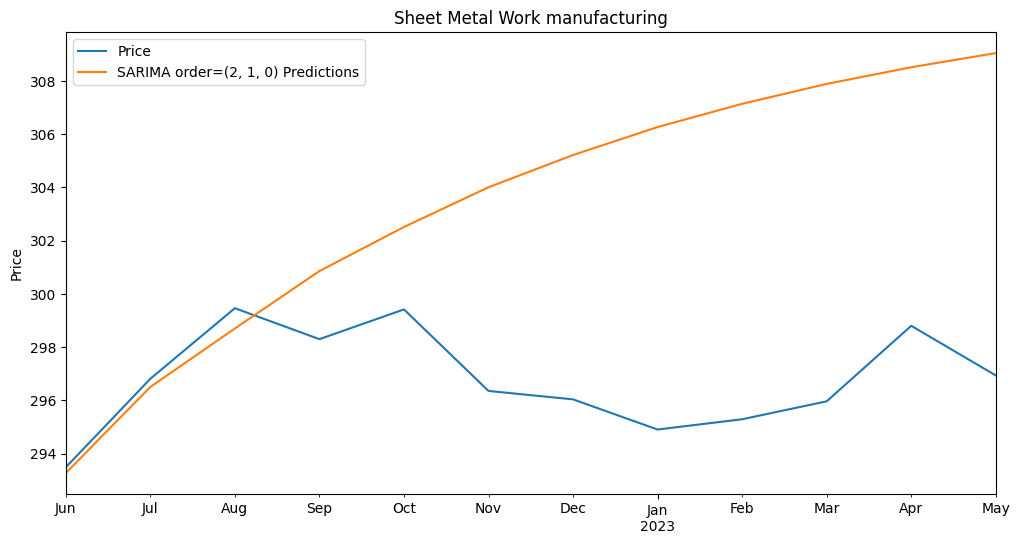

In [103]:
# Plot predictions against known values
title = 'Sheet Metal Work manufacturing'
ylabel='Price'
xlabel=''

ax = test['Price'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [104]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Price'], predictions)
print(f'SARIMA order=(2, 1, 0) MSE Error: {error:11.10}')

SARIMA order=(2, 1, 0) MSE Error: 67.69589151


In [105]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Price'], predictions)
print(f'SARIMA order=(2, 1, 0) RMSE Error: {error:11.10}')

SARIMA order=(2, 1, 0) RMSE Error: 8.227751303


In [106]:
model = SARIMAX(df_new['Price'],order=(0,2,1),seasonal_order=(2, 0, [1, 2], 12))
results = model.fit()
fcast = results.predict(len(df_new),len(df_new)+11,typ='levels').rename('SARIMA order=(2, 1, 0) Forecast')

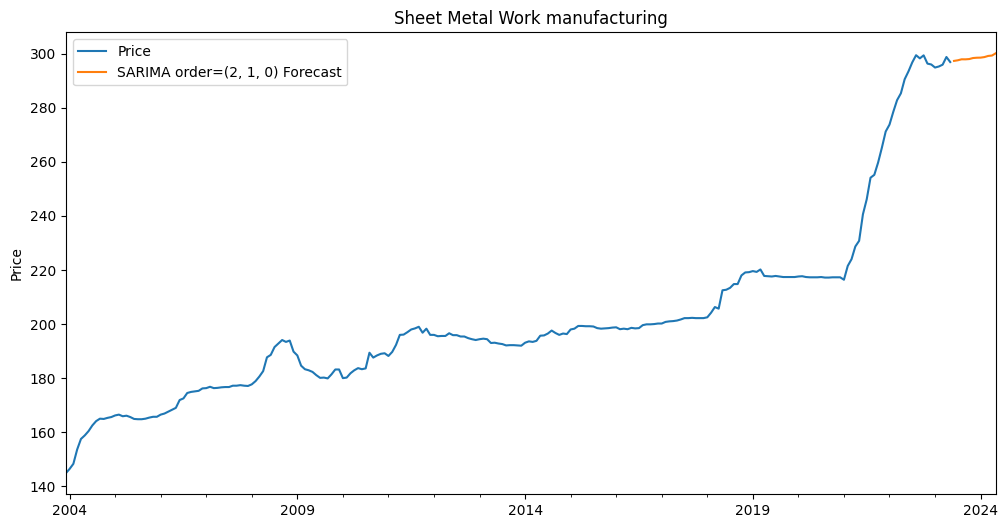

In [107]:
# Plot predictions against known values
title = 'Sheet Metal Work manufacturing'
ylabel='Price'
xlabel=''

ax = df_new['Price'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);